# Analysis of Job Skills (ESCO): Skill Classification using Unsupervised Learning

Author: Sergio Guidon

Date: January 15, 2024

Github link:

# Contents
This notebook is structured as follows:
- Step 1: Data Source and Problem
- Step 2: Unsupervised Learning Problem
- Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
- Step 4: Analysis Using Unsupervised Learning Model, Discussion, and Conclusions

# Step 1: Data Source and Problem

## 1.1 Data Source

ESCO (European Skills, Competences, Qualifications and Occupations) is a dataset connecting job skills to occupations and competences. It contains approximately 3,000 occupations and 14,000 skills relevant to the occupations in the database. In this project, we will focus on skills. The data enables text analysis of skills, as each skill includes a detailed description.

Data source: European Commission. (n.d.). *ESCO classification*. ESCO. Retrieved December 13, 2024, from [https://esco.ec.europa.eu/en/classification](https://esco.ec.europa.eu/en/classification).

## 1.2 Problem Description

Skill transferability is an important aspect for people trying to switch jobs or occupations. This project seeks to predict skill reuse levels (cross-sector, occupation-specific, sector-specific, and transversal) and skill type (knowledge vs skill/competence) solely from descriptions. This could be an interesting task, as lists of skills are often included in job advertisements, and reuse level or skill type could provide important insights into how many potential candidates are available in the job market.

# Step 2: Unsupervised Learning Problem

## 2.1 Unsupervised Learning Problem
Clustering skills into a fixed number of clusters based on their descriptions is an example of an unsupervised learning problem. In the case of the ESCO skills data, we have labels for skill re-use and skil type that we use for validation and interpretation purposes after clustering.

## 2.2 Methods: TF-IDF, K-Means Clustering, and Word2Vec

### TF-IDF (Term Frequency–Inverse Document Frequency)
TF-IDF is a numerical weighting scheme that can be used as a method for information retrieval. It measures the importance of a word to a document, taking into account all words in the set of documents being analyzed. TF refers to the count of a term in a document divided by the total number of terms in that document. IDF is the inverse proportion of documents that contain the term (logarithmically scaled). Thus, TF-IDF provides information about the frequency of a term, and IDF measures how much information the term provides. TF-IDF values are obtained by multiplying TF and IDF. [1]

The output of TF-IDF is a matrix with the shape (n_documents, n_terms) containing the TF-IDF values. This matrix can, for example, be further analyzed using k-means clustering.

### K-Means Clustering
K-Means clustering is a method to assign observations to a set of k clusters [2]. The method iteratively assigns observations to the nearest cluster and then updates the centroids. K-means is one of the methods applied to the TF-IDF matrix in this project. It clusters documents (the observations) based on the TF-IDF values of the terms.

### K-Medoids with Cosine Similarity
As the performance of k-means clustering can be limited with sparse data (such as the TF-IDF matrix), k-medoids with cosine similarity is also used, and the results are compared to k-means clustering.

### Word2Vec
Word2Vec is a natural language processing technique proposed by Google in 2013 to obtain vector representations of words. The vectors contain information about words based on surrounding words and can thus capture semantics (i.e., meaning or interpretation in the context of the set of documents). It uses a shallow neural network architecture, such as CBOW (Continuous Bag of Words) or Skip-gram, both of which involve a single hidden layer. [3]

In this project, Word2Vec is used as an alternative approach to TF-IDF. One could use more complex pre-trained models to achieve better results, but in the scope of this project (experimenting with models), the chosen approach was to use simpler models.

# Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

In this section, we perform EDA (section 3.1) und the results are discussed in section 3.2.

## 3.1 Performing EDA

Outline
- Data inspection
- Data visualization
- Data cleaning

### Data Inspection

In this section, we load the data, check its size and perform basic checks for duplicates, NaN values and types.

In [1]:
# General-purpose libraries
import pandas as pd
import numpy as np
import random
import string
from collections import Counter
random.seed(42)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Additional clustering methods
from sklearn_extra.cluster import KMedoids

# Utility libraries
import itertools


Load and Overview

In [2]:
df = pd.read_csv('skills_en.csv')
df.head()

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,NaN,released,2023-11-30T15:53:37.136Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Assign and manage staff tasks in areas such as...
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00064735-8fad...,skill/competence,occupation-specific,supervise correctional procedures,oversee prison procedures\nmanage correctional...,NaN,released,2023-11-30T15:04:00.689Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Supervise the operations of a correctional fac...
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/000709ed-2be5...,skill/competence,sector-specific,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,NaN,released,2023-11-28T10:45:53.54Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Identify oppression in societies, economies, c..."
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0007bdc2-dd15...,skill/competence,sector-specific,control compliance of railway vehicles regulat...,monitoring of compliance with railway vehicles...,NaN,released,2023-11-30T16:29:18.273Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Inspect rolling stock, components and systems ..."
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00090cc1-1f27...,skill/competence,cross-sector,identify available services,establish available services\ndetermine rehabi...,NaN,released,2023-11-28T10:38:49.206Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Identify the different services available for ...


Check size

In [3]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13939 entries, 0 to 13938
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   conceptType     13939 non-null  object
 1   conceptUri      13939 non-null  object
 2   skillType       13934 non-null  object
 3   reuseLevel      13934 non-null  object
 4   preferredLabel  13939 non-null  object
 5   altLabels       13591 non-null  object
 6   hiddenLabels    153 non-null    object
 7   status          13939 non-null  object
 8   modifiedDate    13939 non-null  object
 9   scopeNote       234 non-null    object
 10  definition      3 non-null      object
 11  inScheme        13939 non-null  object
 12  description     13939 non-null  object
dtypes: object(13)
memory usage: 1.4+ MB
None
(13939, 13)


Check for duplicates and NaN values and drop them

In [4]:
# Check for duplicates
print('Check duplicates')
print(df[df.duplicated()].count())

Check duplicates
conceptType       0
conceptUri        0
skillType         0
reuseLevel        0
preferredLabel    0
altLabels         0
hiddenLabels      0
status            0
modifiedDate      0
scopeNote         0
definition        0
inScheme          0
description       0
dtype: int64


In [5]:
print('Check NaN values')
print(df.isna().sum())

Check NaN values
conceptType           0
conceptUri            0
skillType             5
reuseLevel            5
preferredLabel        0
altLabels           348
hiddenLabels      13786
status                0
modifiedDate          0
scopeNote         13705
definition        13936
inScheme              0
description           0
dtype: int64


In [6]:
# Drop NaN values
df = df.dropna(subset=['reuseLevel'])

Check types

In [7]:
df[['conceptType', 'skillType', 'reuseLevel']] = df[['conceptType', 'skillType', 'reuseLevel']].astype('category')
print(df.dtypes)

conceptType       category
conceptUri          object
skillType         category
reuseLevel        category
preferredLabel      object
altLabels           object
hiddenLabels        object
status              object
modifiedDate        object
scopeNote           object
definition          object
inScheme            object
description         object
dtype: object


### Data visualization

Distribution of skill type

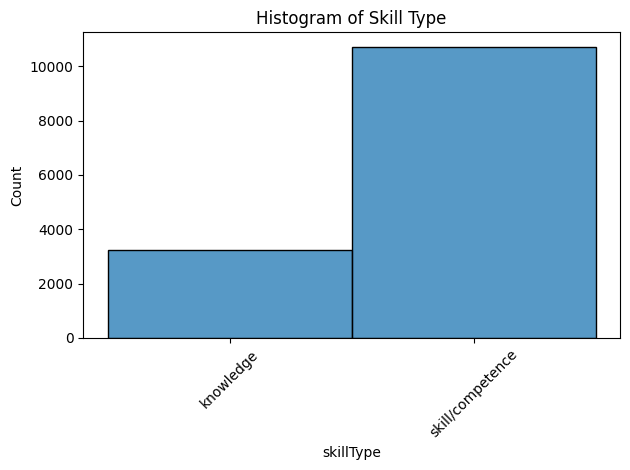

In [8]:
sns.histplot(df['skillType'])
plt.title("Histogram of Skill Type")

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [9]:
skill_type_counts = df['skillType'].value_counts().reset_index()
skill_type_counts.columns = ['Skill Type', 'Count']
print(skill_type_counts.to_string(index=False))

      Skill Type  Count
skill/competence  10715
       knowledge   3219


Distribution of reuse level

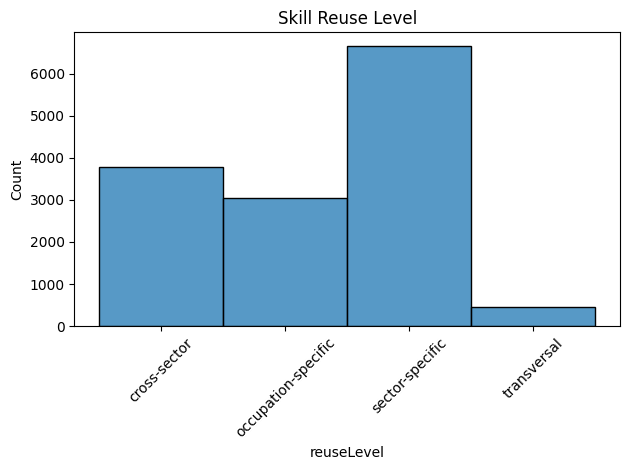

In [10]:
sns.histplot(df['reuseLevel'])
plt.title("Skill Reuse Level")

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [11]:
reuse_level_counts = df['reuseLevel'].value_counts().reset_index()
reuse_level_counts.columns = ['Reuse Level', 'Count']
print(reuse_level_counts.to_string(index=False))

        Reuse Level  Count
    sector-specific   6655
       cross-sector   3783
occupation-specific   3044
        transversal    452


Distribution of description lengths

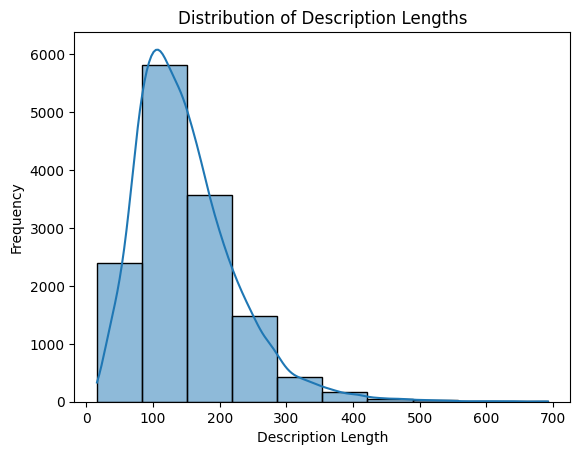

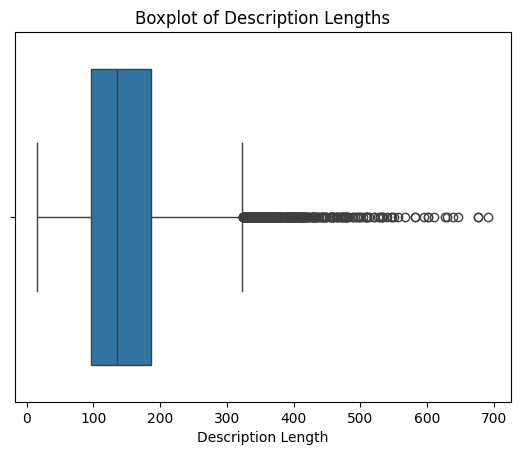

In [12]:
# Distribution of description lengths
sns.histplot(df['description'].str.len(), kde=True, bins=10)
plt.title("Distribution of Description Lengths")
plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.show()

# Boxplot of description lengths
sns.boxplot(x=df['description'].str.len())
plt.title("Boxplot of Description Lengths")
plt.xlabel("Description Length")
plt.show()

Check longest description (to verify that it is not an outlier)

In [13]:
# Get the skill with the longest description
longest_description = df.loc[df['description'].str.len().idxmax(), 'description']
longest_skill = df.loc[df['description'].str.len().idxmax(), 'preferredLabel']
print("Skill:", longest_skill)
print("Description:", longest_description)

Skill: project configuration management
Description: The process for the effective management of the key project artefacts and deliverables, ensuring that the correct versions are delivered to the project requestor and allowing project managers to identify the latest state of project artefacts and be able to gather all sources, documents, and other information for the project, prevent unauthorised changes, guarantee artefacts traceability and return to previous versions. It comprises the identification of project configuration items (CIs), their attributes and status codes, the establishment of baselines, the definition of roles and responsibilities for authorised changes to CIs, and the maintenance and control of a project repository.


### Data Cleaning

Remove stopwords (as they carry little meaning)

In [14]:
# Download and define stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Function removes punctuation and stopwords
def clean_text(text):
    words = text.lower().split()
    cleaned_words = [
        word.strip(string.punctuation)
        for word in words
        if word.strip(string.punctuation) not in stop_words
    ]

    return " ".join(cleaned_words)

df["description_clean"] = df["description"].apply(clean_text)

Check result after stopword removal

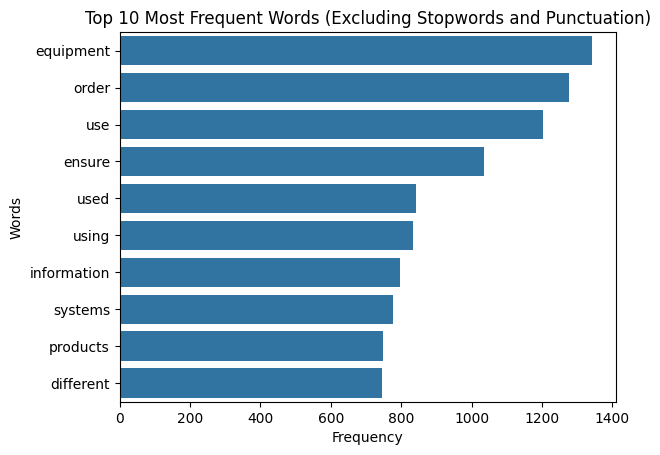

In [16]:
# Join
all_words = " ".join(df["description_clean"]).lower().split()

# Remove punctuation and stopwords
filtered_words = [
    word.strip(string.punctuation)
    for word in all_words
    if word not in stop_words and word.strip(string.punctuation)
]
word_counts = Counter(filtered_words)

# Top 10
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

sns.barplot(x=list(counts), y=list(words))
plt.title("Top 10 Most Frequent Words (Excluding Stopwords and Punctuation)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

Only keep relevant columns

In [17]:
df = df[['skillType', 'reuseLevel', 'description_clean', 'preferredLabel']]

## 3.2 EDA Discussion
**The exploratory data analysis reveals a number of interesting observations:**
- The dataset contains two types of labels: skill type and reuse level. Skill type contains two categories (knowledge and skill/competence), and reuse level contains four categories (cross-sector, occupation-specific, sector-specific, and transversal). These labels can be compared to the clusters obtained by the unsupervised learning model.
- The categories of the two label features are not well balanced. A large share of skill types are in the "skill/competence" category, and in the reuse level feature, "transversal" is rare.
- The description field contains a description for each skill with varying lengths. There are no outliers that need to be removed.
- Basic checks were performed, and NaN values were removed. The data was cleaned by removing stop words and unnecessary columns.

**Insights for further modeling**
- The clusters obtained by the unsupervised learning model will be compared to "skill type" and "reuse level" to check whether the obtained clusters reflect these two aspects of the data.
- Clustering will be performed using cluster numbers of 2 and 4 to match the features "skill type" and "reuse level."
- For visualization purposes, PCA will be performed (to enable showing the obtained clusters on a 2D plot with colors).

# Step 4: Analysis Using Unsupervised Learning Model, Discussion, and Conclusions

## 4.1 Training of unsupervised learning models
- Model 1: TF-IDF and KMeans and K-Mediods Clustering (Skill Re-Use)
- Model 2: Word2Vec and KMeans Clustering (Skill Re-Use)
- Model 3: TF-IDF and Clustering (Skill Type)
- Model 4: TF-IDF and KMeans Clustering (Skill Type) - Hyperparameter Tuning

Helper function for visualizing results

In [18]:
def visualize_clusters_with_top_words(df, feature_names, kmeans, X, cluster_column, num_clusters=4, top_n=3, method='kmeans'):

    if method == 'kmeans':
        top_words = {}
        for i in range(num_clusters):
            cluster_center = kmeans.cluster_centers_[i]
            top_indices = cluster_center.argsort()[-top_n:][::-1]
            top_words[i] = feature_names[top_indices]
    
    if method == 'kmedoids':
        top_words = {}
        for i in range(num_clusters):
            cluster_center_idx = kmedoids.medoid_indices_[i]
            cluster_center = X[cluster_center_idx].flatten()
            top_indices = cluster_center.argsort()[-top_n:][::-1]
            top_words[i] = feature_names[top_indices]
            
    if method == 'kmedoids_word2vec':
        top_words = {}
        for i in range(num_clusters):
            cluster_center_idx = kmedoids.medoid_indices_[i]
            cluster_center = X[cluster_center_idx].flatten()
            top_indices = cluster_center.argsort()[-top_n:][::-1]
            top_words[i] = feature_names[top_indices]
    
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
    pca_df[cluster_column] = df[cluster_column]
    
    cluster_labels = [', '.join(top_words[cluster]) for cluster in df[cluster_column]]
    
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', data=pca_df, hue=cluster_column, palette="Set2", s=100, alpha=0.7, edgecolor='black')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [f'Cluster {i}: {", ".join(top_words[i][:5])}' for i in range(num_clusters)]
    
    plt.legend(handles, new_labels, title=f'Cluster {cluster_column}', loc='upper right')
    plt.title(f'Clustering of Articles based on TF-IDF and K-Means')
    plt.show()

#### Model 1: TF-IDF and KMeans and K-Mediods Clustering (Skill Re-Use)

TF-IDF

In [19]:
df_copy = df.copy()

# train tf-idf
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(df_copy['description_clean'])

feature_names = np.array(vectorizer.get_feature_names_out())

K-Means Clustering

In [20]:
# Clustering
num_clusters = 4

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_copy['Cluster_kmeans'] = kmeans.fit_predict(X_tfidf)

K-Medoids with Cosine Similarity

In [21]:
cosine_sim = cosine_distances(X_tfidf)

kmedoids = KMedoids(n_clusters=num_clusters, metric='precomputed', random_state=42)
df_copy['Cluster_kmediods'] = kmedoids.fit_predict(cosine_sim)

Visualizing K-Means

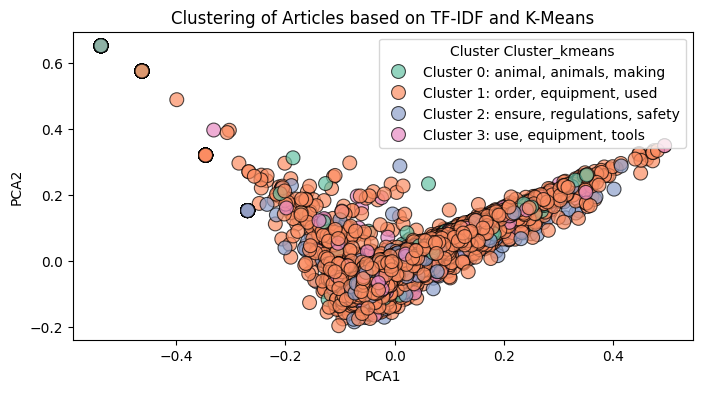

In [22]:
visualize_clusters_with_top_words(df_copy, feature_names, kmeans, X_tfidf.toarray(), 'Cluster_kmeans')

Visualizing K-Mediods

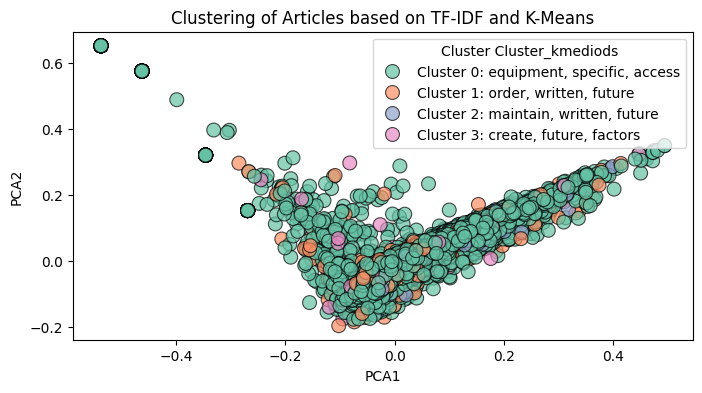

In [23]:
visualize_clusters_with_top_words(df_copy, feature_names, kmeans, X_tfidf.toarray(), 'Cluster_kmediods', method='kmedoids')

#### Model 2: Word2Vec and KMeans Clustering (Skill Re-Use)

Word2Vec Training

In [24]:
# Tokenize
sentences = [desc.split() for desc in df_copy['description_clean']]
model = Word2Vec(sentences, vector_size=300, window=100, min_count=10, sg=0)

# Get document vectors
def get_document_vector(model, words):
    valid_words = [word for word in words if word in model.wv]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

df_copy['Document_Vector'] = df_copy['description_clean'].apply(lambda x: get_document_vector(model, x.split()))
X = np.array(df_copy['Document_Vector'].tolist())


Get top words (most similar)

In [25]:
feature_names_word2vec = np.array(model.wv.index_to_key)

K-Medoids with Cosine Similarity

In [26]:
cosine_sim = cosine_distances(X)

kmedoids = KMedoids(n_clusters=num_clusters, metric='precomputed', random_state=42)
df_copy['Cluster_word2vec_mediods'] = kmedoids.fit_predict(cosine_sim)

Visualizing Word2Vec Results

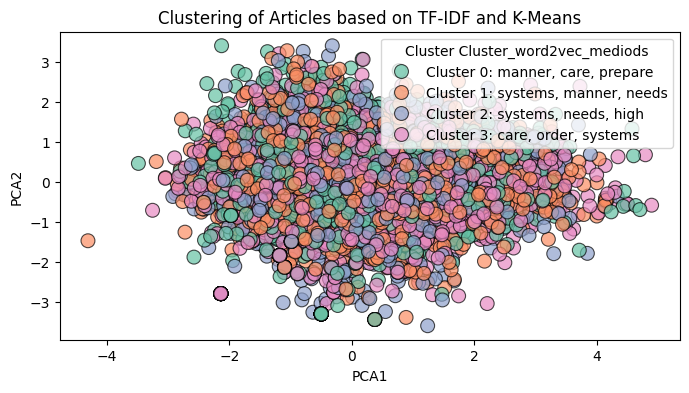

In [27]:
visualize_clusters_with_top_words(df_copy, feature_names_word2vec, kmedoids, X, 'Cluster_word2vec_mediods', method='kmedoids_word2vec')

Inspect final data

In [28]:
df_copy.head()

,skillType,reuseLevel,description_clean,preferredLabel,Cluster_kmeans,Cluster_kmediods,Document_Vector,Cluster_word2vec_mediods
0,skill/competence,sector-specific,assign manage staff tasks areas scoring arrang...,manage musical staff,1,0,"[0.0047092694, 0.14027551, 0.0052536163, 0.113...",1
1,skill/competence,occupation-specific,supervise operations correctional facility cor...,supervise correctional procedures,2,0,"[-0.06996893, 0.13083707, -0.053540275, 0.1028...",0
2,skill/competence,sector-specific,identify oppression societies economies cultur...,apply anti-oppressive practices,1,0,"[0.06813438, 0.11197623, 0.0072864583, 0.10850...",1
3,skill/competence,sector-specific,inspect rolling stock components systems ensur...,control compliance of railway vehicles regulat...,2,0,"[-0.42260918, 0.49272358, 0.037665367, 0.26303...",3
4,skill/competence,cross-sector,identify different services available offender...,identify available services,1,1,"[0.12494923, 0.16399452, 0.01843425, 0.1056622...",1


Compare cluster to label

In [29]:
top_10_labels_per_cluster = df_copy.groupby('Cluster_word2vec_mediods')['preferredLabel'].value_counts().groupby(level=0).head(3).reset_index(name='count')
print(top_10_labels_per_cluster)

    Cluster_word2vec_mediods  \
0                          0   
1                          0   
2                          0   
3                          1   
4                          1   
5                          1   
6                          2   
7                          2   
8                          2   
9                          3   
10                         3   
11                         3   

                                       preferredLabel  count  
0                                      5S methodology      1  
1   European Structural and Investment Funds regul...      1  
2                       European Train Control System      1  
3                                     African studies      1  
4                            Agile project management      1  
5                                            Buddhism      1  
6                       3D body scanning technologies      1  
7                                         3D lighting      1  
8               

In [30]:
reuse_level_counts = df_copy.groupby('Cluster_word2vec_mediods')['reuseLevel'].value_counts().unstack().fillna(0)
print(reuse_level_counts)

reuseLevel                cross-sector  occupation-specific  sector-specific  \
Cluster_word2vec_mediods                                                       
0                                  745                  673             1456   
1                                 1324                  738             1833   
2                                  672                  446             1267   
3                                 1042                 1187             2099   

reuseLevel                transversal  
Cluster_word2vec_mediods               
0                                  16  
1                                 147  
2                                 285  
3                                   4  


#### Comparison of Skill Clusters to Re-Use Levels

Helper function 1: assign clusters to labels

In [31]:
# This code is from my submission for week 2 (adapted).

def label_permute_compare(ytdf, yp, n=4, col='reuseLevel'):
    permutations = list(itertools.permutations(range(n)))
    unique_classes = ytdf[col].unique()
    
    acc = []
    for permutation in permutations:
        perm_dict = dict(list(zip(unique_classes, permutation)))
        labels_data = ytdf[col].map(perm_dict)
        
        acc.append(accuracy_score(labels_data, yp))
        
    i_max_acc = np.argmax(acc)
    
    return permutations[i_max_acc], acc[i_max_acc]

Helper function 2: visualize and print accuracy

In [32]:
def evaluate_clustering_accuracy(df, true_column, predicted_column, n=4):
    labels_train = pd.DataFrame(df[true_column])
    labels_model = pd.DataFrame(df[predicted_column])
    labelorder, acc = label_permute_compare(labels_train, labels_model, n=n, col=true_column)
    
    print('---- Accuracy ----')
    print(labelorder, acc)

    unique_classes = df[true_column].unique()
    perm_dict = dict(zip(unique_classes, labelorder))
    labels_data = df[true_column].map(perm_dict)

    cm = confusion_matrix(y_true=labels_data, y_pred=labels_model)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

##### Word2Vec with K-Mediods - Skill Re-Use

---- Accuracy ----
(3, 0, 1, 2) 0.3144107937419262


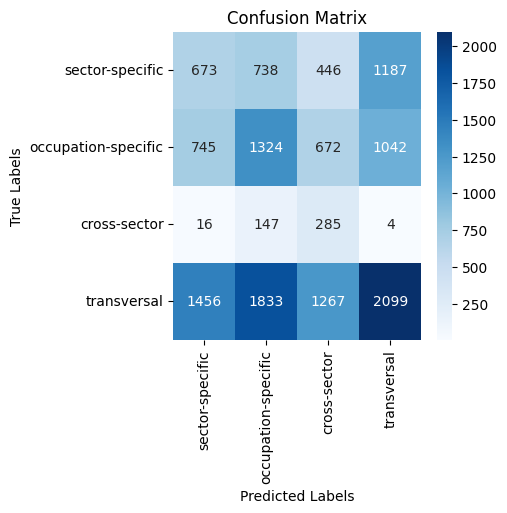

In [33]:
evaluate_clustering_accuracy(df_copy, 'reuseLevel', 'Cluster_word2vec_mediods')

##### TF-IDF with K-Means - Skill Re-Use

---- Accuracy ----
(1, 3, 2, 0) 0.42636715946605425


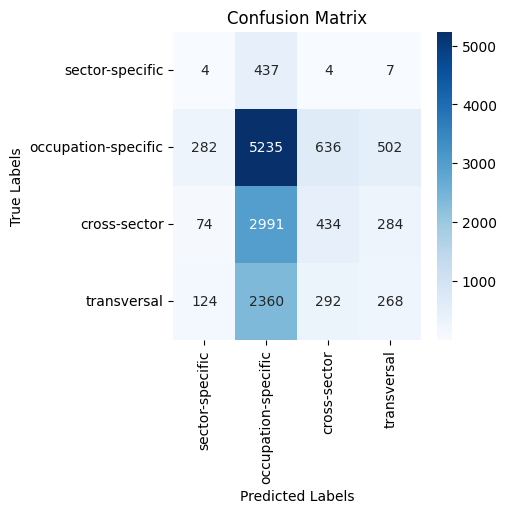

In [34]:
evaluate_clustering_accuracy(df_copy, 'reuseLevel', 'Cluster_kmeans')

##### TF-IDF with K-Mediods - Skill Re-Use

---- Accuracy ----
(0, 2, 1, 3) 0.45277737907277166


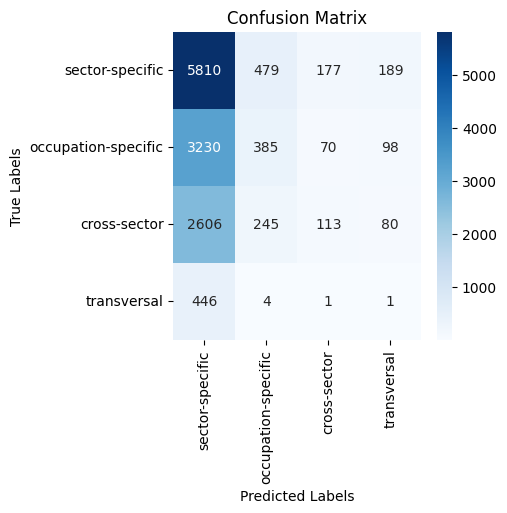

In [35]:
evaluate_clustering_accuracy(df_copy, 'reuseLevel', 'Cluster_kmediods')

#### Model 3: TF-IDF and KMeans Clustering (Skill Type)

K-Means Clustering

In [36]:
# Clustering
num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_copy['Cluster_kmeans_2'] = kmeans.fit_predict(X_tfidf)

feature_names = np.array(vectorizer.get_feature_names_out())

Visualizing Results

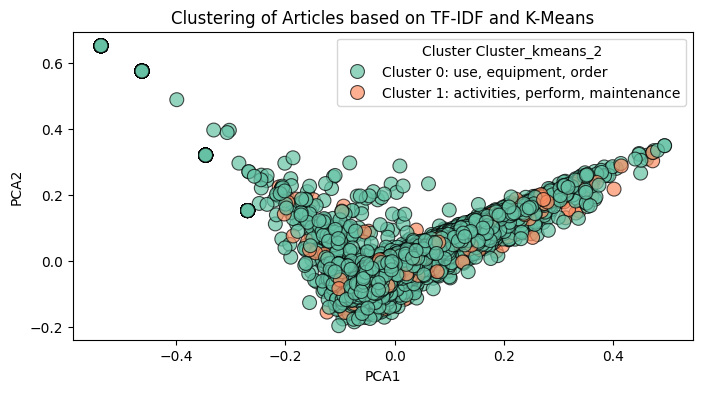

In [37]:
visualize_clusters_with_top_words(df_copy, feature_names, kmeans, X_tfidf, 'Cluster_kmeans_2', num_clusters=2)


##### TF-IDF with K-Means - Skill Type

---- Accuracy ----
(0, 1) 0.7173101765465767


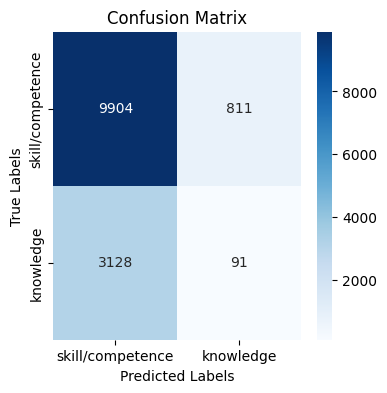

In [38]:
evaluate_clustering_accuracy(df_copy, 'skillType', 'Cluster_kmeans_2', n=2)

#### Model 4: TF-IDF and KMeans Clustering (Skill Type) - Hyperparameter Tuning

In this section, TF-IDF is re-run with hyperparameter tuning using a custom silhouette scorer. The necessary steps are also combined into a pipeline.

In [39]:
def custom_silhouette_scorer(estimator, X):
    transformed_X = estimator.named_steps['tfidf'].transform(X)
    labels = estimator.named_steps['kmeans'].predict(transformed_X)
    return silhouette_score(transformed_X, labels)


# Combine steps in a pupeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

# Parameter grid
param_grid = {
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 5000, None]
}

# Grid Search 
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=custom_silhouette_scorer, 
    cv=5,
    verbose=1
)

grid_search.fit(df_copy['description_clean'])

# Assign clusters to the DataFrame
best_pipeline = grid_search.best_estimator_
df_copy['clusters_grid'] = best_pipeline.named_steps['kmeans'].labels_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


---- Accuracy ----
(0, 3, 2, 1) 0.40785129898091


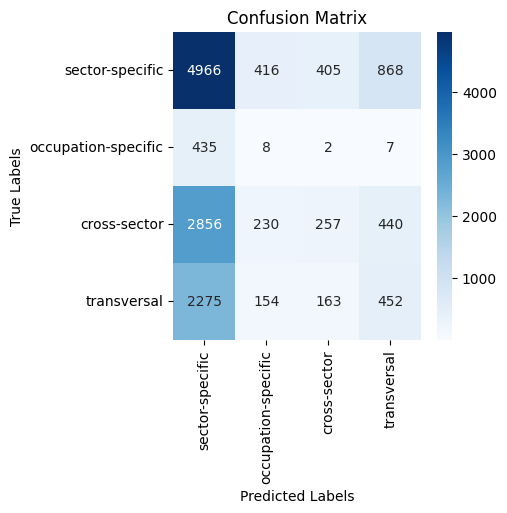

In [40]:
evaluate_clustering_accuracy(df_copy, 'reuseLevel', 'clusters_grid')

## 4.2 Discussion

In this project, three unsupervised models were used to cluster skills descriptions and compare the obtained clusters to the original labels 'skill type' and 'skill re-use'. The two approaches were 1) to combine TD-IDF with k-means and k-mediods, and 2) combining Word2Vec with K-Means.

### Summary of results:

| Model                          | Accuracy                   |
|---------------------------------|----------------------------|
| Word2Vec with K-Mediods - Skill Re-Use  | 0.3012                     |
| TF-IDF with K-Means - Skill Re-Use      | 0.4264                     |
| TF-IDF with K-Mediods - Skill Re-Use    | 0.4528                     |
| TF-IDF with K-Means and hyperparameter tuning - Skill Re-Use    | 0.4078 |
| TF-IDF with K-Means - Skill Type       | 0.7173                     |



If we assigned Skill Re-Use randomly to categories, accuracy would be 0.25 (4 categories). If we assigned Skill Type randomly, accuracy would be 0.5 (2 categories). The models trained in this project perform much better than random. This could be due to the fact that the models are indeed able to extract information about those two categories from the skills' descriptions.

For skill re-use, the best results were obtained by combining TF-IDF with K-Mediods. The improvement compared to using K-means is minimal. Word2Vec, being a more powerful model, may have led to clusters that were less comparable to the label of "skill re-use" because it focuses more on capturing semantic relationships between words. These semantic relationships might not align well with the explicit, category-based distinctions required for "skill re-use". This could have resulted in clusters that were more abstract or less relevant to the skill re-use categories.

Hyperparameter tuning using the silhouette coefficient as a scorer did not lead to clusters that are closer to the skill reuse clusters present in the data. However, the approach may still be reasonable if the goal is to increase cohesion


## 4.3 Conclusion

In this project, experiments were conducted with the goal of clustering skills and checking whether the clusters contain information about skill reuse levels (cross-sector, occupation-specific, sector-specific, and transversal) and skill type (knowledge vs. skill/competence). The results indicate that combining TF-IDF with K-means and K-medoids does indeed lead to clusters that can be interpreted with respect to the provided skill reuse and skill type labels. Word2Vec likely resulted in clusters that were less comparable to these labels.

The method outlined above could potentially be used to analyze the skill section of job advertisements with respect to reusability and skill type. However, a more straightforward approach would be to use the full ESCO dataset, compare the skill section to the skills in the database, and utilize the provided relationships between the skills. Although out of scope for this project, this could be an interesting future endeavor.

# References

[1] Wikipedia contributors. (n.d.). *Tf–idf*. Wikipedia. Retrieved December 14, 2024, from [https://en.wikipedia.org/wiki/Tf–idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

[2] Wikipedia contributors. (n.d.). *K-means clustering*. Wikipedia. Retrieved December 14, 2024, from [https://en.wikipedia.org/wiki/K-means_clustering](https://en.wikipedia.org/wiki/K-means_clustering)

[3] Wikipedia contributors. (n.d.). *Word2vec*. Wikipedia. Retrieved December 14, 2024, from [https://en.wikipedia.org/wiki/Word2vec](https://en.wikipedia.org/wiki/Word2vec)
